In [1]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 
NPY_INPUT_DIR = '../data/extracted_features/combined_ML/maria/'
NPY_OUTPUT_DIR = '../data/resultsML/maria/'

NUM_TESTS = 25

HIDDEN_DIM0 = 234
NUM_LAYERS0 = 2
BIDIRECTIONAL = True
LEARNING_RATE0 =  0.01418295487782988
IMAGE_HIDDEN= 175
DECAY_FACTOR0 = 0.17451446516351246
EPOCH0 = 4

HIDDEN_DIM1 = 241
NUM_LAYERS1 = 2
ACTIVATION1 = torch.relu
LEARNING_RATE1 =  0.009526187612921844
MOMENTUM1= 0.9
DECAY_FACTOR1 =  0.15806602575114242
EPOCH1 = 3

HIDDEN_DIM2 = 210
NUM_LAYERS2 = 1
ACTIVATION2 = torch.sigmoid
LEARNING_RATE2 =   0.011475172596199481
MOMENTUM2= 0.9
DECAY_FACTOR2 =  0.3837225134241784
EPOCH2 = 4



# LSTM -------------------------------------------------------------------*

In [3]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test, X_img_train, X_img_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, img_hidden_dim = IMAGE_HIDDEN,
                          num_layers = NUM_LAYERS0, bidirectional = BIDIRECTIONAL,
                          learning_rate = LEARNING_RATE0,decay_factor = DECAY_FACTOR0)
        model.learn(X_train, X_img_train, y_train, epochs=EPOCH0)
        
        # evaluate
        acc, auc, precision, recall, f1 = model.get_acc_auc_pre_re_f1(X_test, X_img_test, y_test)
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = model.get_accuracy_graph(X_test, X_img_test, y_test, y_train.numpy())
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'lstm_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [4]:
# load data from files
X_seq_img_train = np.load(NPY_INPUT_DIR + 'images_lstm_train.npz', allow_pickle=True)
X_seq_img_test = np.load(NPY_INPUT_DIR + 'images_lstm_test.npz', allow_pickle=True)

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))


# build lists with features concatenated
# img feat
X_raw_img_train = []
for i in range(len(y_train)):
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_raw_img_train.append(hist[j])

img_scaler = StandardScaler()
X_img_fit_train = np.concatenate(X_raw_img_train) # a stack of all image feat
img_scaler.fit(X_img_fit_train)

# now build list of list of normalized 2d matricies representing all img in a tweet
X_img_train = []
for i in range(len(y_train)):
    X_i_img = []
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_train.append(X_i_img)
    
X_img_test = []
for i in range(len(y_test)):
    X_i_img = []
    file = X_seq_img_test.files[i]
    hist = X_seq_img_test[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_test.append(X_i_img)

# lang feat
X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.604
[1,   400] loss: 0.491
[1,   600] loss: 0.530
[1,   800] loss: 0.417
[1,  1000] loss: 0.568
[1,  1200] loss: 0.494
[1,  1400] loss: 0.427
[1,  1600] loss: 0.441
[1,  1800] loss: 0.448
[1,  2000] loss: 0.429
[1,  2200] loss: 0.487
[1,  2400] loss: 0.445
[1,  2600] loss: 0.460
[1,  2800] loss: 0.437
[1,  3000] loss: 0.429
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.367
[2,   400] loss: 0.282
[2,   600] loss: 0.347
[2,   800] loss: 0.323
[2,  1000] loss: 0.340
[2,  1200] loss: 0.285
[2,  1400] loss: 0.263
[2,  1600] loss: 0.303
[2,  1800] loss: 0.317
[2,  2000] loss: 0.273
[2,  2200] loss: 0.314
[2,  2400] loss: 0.261
[2,  2600] loss: 0.226
[2,  2800] loss: 0.299
[2,  3000] loss: 0.209
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.169
[3,   400] loss: 0.186
[3,   600] loss: 0.224
[3,   800] loss: 0.205
[3,  1000] loss: 0.219
[3,  1200] loss: 0.219
[3,  1400] loss: 0.173
[3,  160

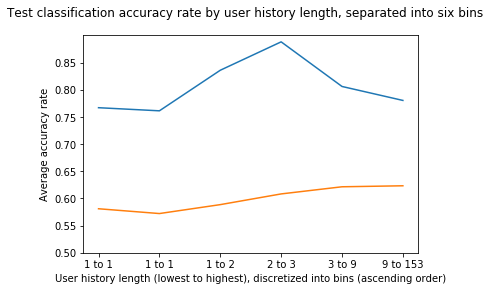

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.604
[1,   400] loss: 0.494
[1,   600] loss: 0.528
[1,   800] loss: 0.423
[1,  1000] loss: 0.566
[1,  1200] loss: 0.491
[1,  1400] loss: 0.427
[1,  1600] loss: 0.440
[1,  1800] loss: 0.449
[1,  2000] loss: 0.432
[1,  2200] loss: 0.484
[1,  2400] loss: 0.443
[1,  2600] loss: 0.461
[1,  2800] loss: 0.441
[1,  3000] loss: 0.421
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.362
[2,   400] loss: 0.271
[2,   600] loss: 0.342
[2,   800] loss: 0.323
[2,  1000] loss: 0.341
[2,  1200] loss: 0.283
[2,  1400] loss: 0.262
[2,  1600] loss: 0.302
[2,  1800] loss: 0.317
[2,  2000] loss: 0.269
[2,  2200] loss: 0.313
[2,  2400] loss: 0.265
[2,  2600] loss: 0.237
[2,  2800] loss: 0.308
[2,  3000] loss: 0.208
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.175
[3,   400] loss: 0.186
[3,   600] loss: 0.230
[3,   800] loss: 0.201
[3,  1000] loss: 0.222
[3,  1200] loss: 0.219
[3,  1400] loss: 0.161
[3,  160

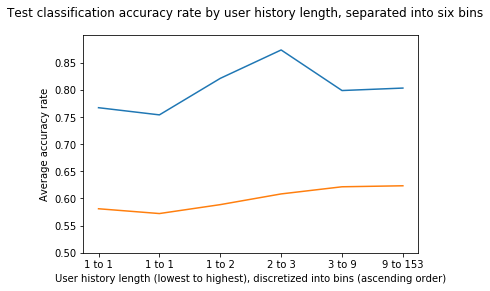

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.611
[1,   400] loss: 0.491
[1,   600] loss: 0.532
[1,   800] loss: 0.418
[1,  1000] loss: 0.568
[1,  1200] loss: 0.493
[1,  1400] loss: 0.424
[1,  1600] loss: 0.436
[1,  1800] loss: 0.447
[1,  2000] loss: 0.433
[1,  2200] loss: 0.488
[1,  2400] loss: 0.441
[1,  2600] loss: 0.461
[1,  2800] loss: 0.441
[1,  3000] loss: 0.423
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.361
[2,   400] loss: 0.273
[2,   600] loss: 0.348
[2,   800] loss: 0.331
[2,  1000] loss: 0.337
[2,  1200] loss: 0.283
[2,  1400] loss: 0.262
[2,  1600] loss: 0.309
[2,  1800] loss: 0.310
[2,  2000] loss: 0.275
[2,  2200] loss: 0.307
[2,  2400] loss: 0.253
[2,  2600] loss: 0.229
[2,  2800] loss: 0.304
[2,  3000] loss: 0.206
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.169
[3,   400] loss: 0.184
[3,   600] loss: 0.234
[3,   800] loss: 0.199
[3,  1000] loss: 0.217
[3,  1200] loss: 0.200
[3,  1400] loss: 0.165
[3,  160

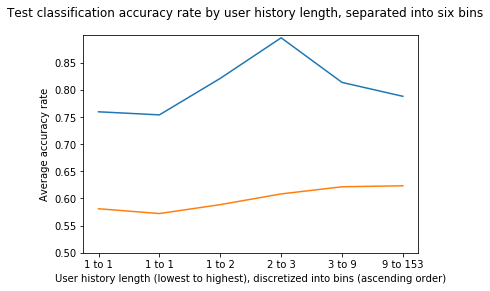

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.603
[1,   400] loss: 0.487
[1,   600] loss: 0.534
[1,   800] loss: 0.418
[1,  1000] loss: 0.562
[1,  1200] loss: 0.494
[1,  1400] loss: 0.425
[1,  1600] loss: 0.439
[1,  1800] loss: 0.452
[1,  2000] loss: 0.433
[1,  2200] loss: 0.489
[1,  2400] loss: 0.435
[1,  2600] loss: 0.458
[1,  2800] loss: 0.441
[1,  3000] loss: 0.428
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.362
[2,   400] loss: 0.277
[2,   600] loss: 0.348
[2,   800] loss: 0.328
[2,  1000] loss: 0.336
[2,  1200] loss: 0.282
[2,  1400] loss: 0.267
[2,  1600] loss: 0.305
[2,  1800] loss: 0.313
[2,  2000] loss: 0.278
[2,  2200] loss: 0.315
[2,  2400] loss: 0.269
[2,  2600] loss: 0.232
[2,  2800] loss: 0.301
[2,  3000] loss: 0.213
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.181
[3,   400] loss: 0.194
[3,   600] loss: 0.232
[3,   800] loss: 0.208
[3,  1000] loss: 0.216
[3,  1200] loss: 0.213
[3,  1400] loss: 0.168
[3,  160

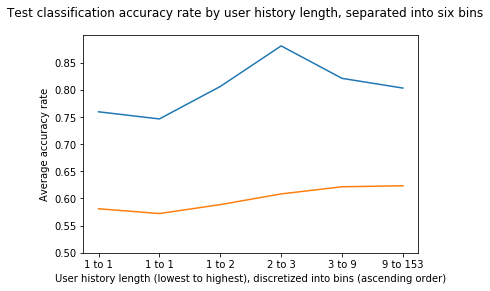

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.607
[1,   400] loss: 0.493
[1,   600] loss: 0.533
[1,   800] loss: 0.423
[1,  1000] loss: 0.562
[1,  1200] loss: 0.488
[1,  1400] loss: 0.427
[1,  1600] loss: 0.436
[1,  1800] loss: 0.448
[1,  2000] loss: 0.433
[1,  2200] loss: 0.486
[1,  2400] loss: 0.441
[1,  2600] loss: 0.459
[1,  2800] loss: 0.441
[1,  3000] loss: 0.425
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.354
[2,   400] loss: 0.273
[2,   600] loss: 0.334
[2,   800] loss: 0.321
[2,  1000] loss: 0.336
[2,  1200] loss: 0.278
[2,  1400] loss: 0.259
[2,  1600] loss: 0.299
[2,  1800] loss: 0.309
[2,  2000] loss: 0.267
[2,  2200] loss: 0.302
[2,  2400] loss: 0.255
[2,  2600] loss: 0.221
[2,  2800] loss: 0.290
[2,  3000] loss: 0.199
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.174
[3,   400] loss: 0.174
[3,   600] loss: 0.209
[3,   800] loss: 0.197
[3,  1000] loss: 0.207
[3,  1200] loss: 0.194
[3,  1400] loss: 0.162
[3,  160

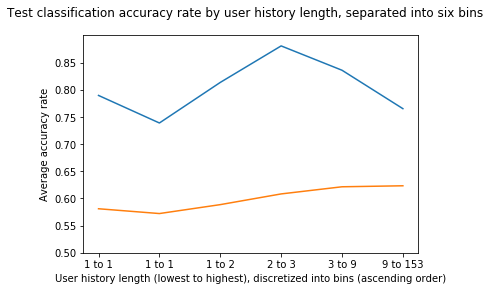

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.603
[1,   400] loss: 0.488
[1,   600] loss: 0.534
[1,   800] loss: 0.418
[1,  1000] loss: 0.566
[1,  1200] loss: 0.492
[1,  1400] loss: 0.431
[1,  1600] loss: 0.435
[1,  1800] loss: 0.449
[1,  2000] loss: 0.432
[1,  2200] loss: 0.487
[1,  2400] loss: 0.446
[1,  2600] loss: 0.464
[1,  2800] loss: 0.444
[1,  3000] loss: 0.425
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.357
[2,   400] loss: 0.280
[2,   600] loss: 0.349
[2,   800] loss: 0.323
[2,  1000] loss: 0.339
[2,  1200] loss: 0.286
[2,  1400] loss: 0.268
[2,  1600] loss: 0.306
[2,  1800] loss: 0.320
[2,  2000] loss: 0.276
[2,  2200] loss: 0.315
[2,  2400] loss: 0.269
[2,  2600] loss: 0.232
[2,  2800] loss: 0.311
[2,  3000] loss: 0.216
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.185
[3,   400] loss: 0.191
[3,   600] loss: 0.230
[3,   800] loss: 0.208
[3,  1000] loss: 0.227
[3,  1200] loss: 0.207
[3,  1400] loss: 0.171
[3,  160

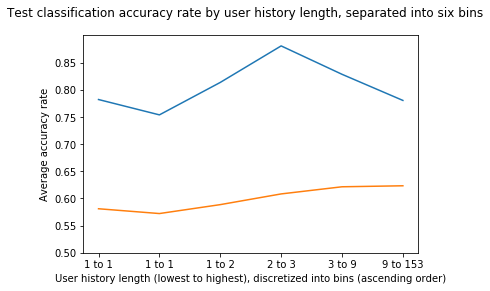

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.607
[1,   400] loss: 0.489
[1,   600] loss: 0.534
[1,   800] loss: 0.420
[1,  1000] loss: 0.566
[1,  1200] loss: 0.493
[1,  1400] loss: 0.426
[1,  1600] loss: 0.433
[1,  1800] loss: 0.452
[1,  2000] loss: 0.433
[1,  2200] loss: 0.485
[1,  2400] loss: 0.445
[1,  2600] loss: 0.460
[1,  2800] loss: 0.438
[1,  3000] loss: 0.423
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.363
[2,   400] loss: 0.277
[2,   600] loss: 0.341
[2,   800] loss: 0.321
[2,  1000] loss: 0.334
[2,  1200] loss: 0.280
[2,  1400] loss: 0.261
[2,  1600] loss: 0.304
[2,  1800] loss: 0.311
[2,  2000] loss: 0.271
[2,  2200] loss: 0.313
[2,  2400] loss: 0.269
[2,  2600] loss: 0.232
[2,  2800] loss: 0.301
[2,  3000] loss: 0.213
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.176
[3,   400] loss: 0.188
[3,   600] loss: 0.228
[3,   800] loss: 0.196
[3,  1000] loss: 0.218
[3,  1200] loss: 0.204
[3,  1400] loss: 0.170
[3,  160

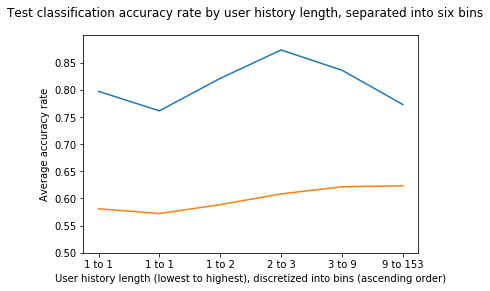

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.610
[1,   400] loss: 0.491
[1,   600] loss: 0.533
[1,   800] loss: 0.422
[1,  1000] loss: 0.563
[1,  1200] loss: 0.494
[1,  1400] loss: 0.426
[1,  1600] loss: 0.437
[1,  1800] loss: 0.451
[1,  2000] loss: 0.431
[1,  2200] loss: 0.485
[1,  2400] loss: 0.445
[1,  2600] loss: 0.460
[1,  2800] loss: 0.438
[1,  3000] loss: 0.428
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.358
[2,   400] loss: 0.276
[2,   600] loss: 0.346
[2,   800] loss: 0.329
[2,  1000] loss: 0.335
[2,  1200] loss: 0.284
[2,  1400] loss: 0.262
[2,  1600] loss: 0.296
[2,  1800] loss: 0.309
[2,  2000] loss: 0.268
[2,  2200] loss: 0.314
[2,  2400] loss: 0.269
[2,  2600] loss: 0.230
[2,  2800] loss: 0.303
[2,  3000] loss: 0.207
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.176
[3,   400] loss: 0.185
[3,   600] loss: 0.233
[3,   800] loss: 0.199
[3,  1000] loss: 0.227
[3,  1200] loss: 0.206
[3,  1400] loss: 0.161
[3,  160

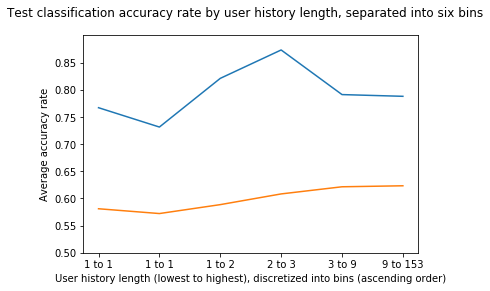

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.608
[1,   400] loss: 0.495
[1,   600] loss: 0.533
[1,   800] loss: 0.425
[1,  1000] loss: 0.566
[1,  1200] loss: 0.490
[1,  1400] loss: 0.423
[1,  1600] loss: 0.439
[1,  1800] loss: 0.447
[1,  2000] loss: 0.432
[1,  2200] loss: 0.489
[1,  2400] loss: 0.442
[1,  2600] loss: 0.462
[1,  2800] loss: 0.436
[1,  3000] loss: 0.429
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.368
[2,   400] loss: 0.274
[2,   600] loss: 0.346
[2,   800] loss: 0.327
[2,  1000] loss: 0.340
[2,  1200] loss: 0.282
[2,  1400] loss: 0.265
[2,  1600] loss: 0.309
[2,  1800] loss: 0.318
[2,  2000] loss: 0.272
[2,  2200] loss: 0.312
[2,  2400] loss: 0.266
[2,  2600] loss: 0.233
[2,  2800] loss: 0.316
[2,  3000] loss: 0.212
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.184
[3,   400] loss: 0.185
[3,   600] loss: 0.229
[3,   800] loss: 0.203
[3,  1000] loss: 0.226
[3,  1200] loss: 0.222
[3,  1400] loss: 0.171
[3,  160

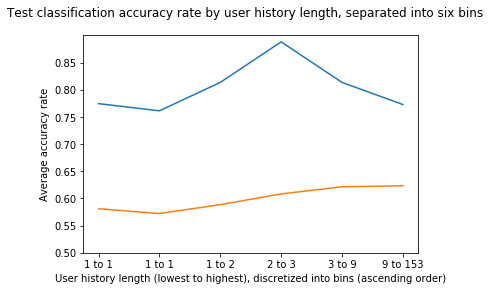

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.607
[1,   400] loss: 0.491
[1,   600] loss: 0.533
[1,   800] loss: 0.421
[1,  1000] loss: 0.564
[1,  1200] loss: 0.490
[1,  1400] loss: 0.428
[1,  1600] loss: 0.439
[1,  1800] loss: 0.448
[1,  2000] loss: 0.433
[1,  2200] loss: 0.486
[1,  2400] loss: 0.444
[1,  2600] loss: 0.460
[1,  2800] loss: 0.436
[1,  3000] loss: 0.427
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.361
[2,   400] loss: 0.276
[2,   600] loss: 0.348
[2,   800] loss: 0.326
[2,  1000] loss: 0.336
[2,  1200] loss: 0.280
[2,  1400] loss: 0.265
[2,  1600] loss: 0.297
[2,  1800] loss: 0.318
[2,  2000] loss: 0.272
[2,  2200] loss: 0.308
[2,  2400] loss: 0.263
[2,  2600] loss: 0.236
[2,  2800] loss: 0.303
[2,  3000] loss: 0.203
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.178
[3,   400] loss: 0.193
[3,   600] loss: 0.222
[3,   800] loss: 0.203
[3,  1000] loss: 0.220
[3,  1200] loss: 0.212
[3,  1400] loss: 0.163
[3,  160

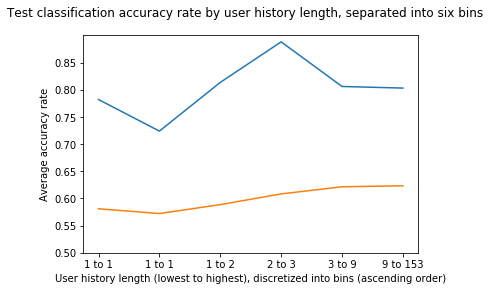

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.607
[1,   400] loss: 0.491
[1,   600] loss: 0.534
[1,   800] loss: 0.426
[1,  1000] loss: 0.564
[1,  1200] loss: 0.493
[1,  1400] loss: 0.428
[1,  1600] loss: 0.439
[1,  1800] loss: 0.448
[1,  2000] loss: 0.430
[1,  2200] loss: 0.490
[1,  2400] loss: 0.445
[1,  2600] loss: 0.460
[1,  2800] loss: 0.442
[1,  3000] loss: 0.427
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.373
[2,   400] loss: 0.281
[2,   600] loss: 0.358
[2,   800] loss: 0.339
[2,  1000] loss: 0.346
[2,  1200] loss: 0.292
[2,  1400] loss: 0.274
[2,  1600] loss: 0.320
[2,  1800] loss: 0.323
[2,  2000] loss: 0.283
[2,  2200] loss: 0.321
[2,  2400] loss: 0.277
[2,  2600] loss: 0.245
[2,  2800] loss: 0.329
[2,  3000] loss: 0.230
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.197
[3,   400] loss: 0.207
[3,   600] loss: 0.247
[3,   800] loss: 0.231
[3,  1000] loss: 0.238
[3,  1200] loss: 0.235
[3,  1400] loss: 0.194
[3,  160

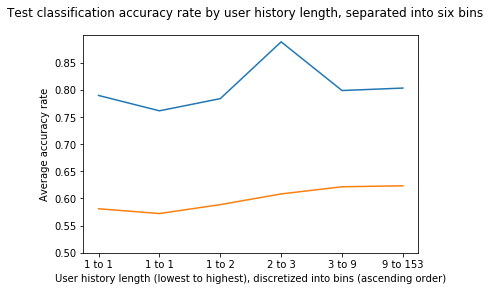

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.603
[1,   400] loss: 0.489
[1,   600] loss: 0.537
[1,   800] loss: 0.422
[1,  1000] loss: 0.567
[1,  1200] loss: 0.492
[1,  1400] loss: 0.427
[1,  1600] loss: 0.439
[1,  1800] loss: 0.450
[1,  2000] loss: 0.432
[1,  2200] loss: 0.488
[1,  2400] loss: 0.445
[1,  2600] loss: 0.460
[1,  2800] loss: 0.435
[1,  3000] loss: 0.427
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.363
[2,   400] loss: 0.274
[2,   600] loss: 0.346
[2,   800] loss: 0.327
[2,  1000] loss: 0.341
[2,  1200] loss: 0.285
[2,  1400] loss: 0.259
[2,  1600] loss: 0.310
[2,  1800] loss: 0.321
[2,  2000] loss: 0.272
[2,  2200] loss: 0.308
[2,  2400] loss: 0.261
[2,  2600] loss: 0.236
[2,  2800] loss: 0.303
[2,  3000] loss: 0.207
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.174
[3,   400] loss: 0.191
[3,   600] loss: 0.225
[3,   800] loss: 0.204
[3,  1000] loss: 0.215
[3,  1200] loss: 0.199
[3,  1400] loss: 0.166
[3,  160

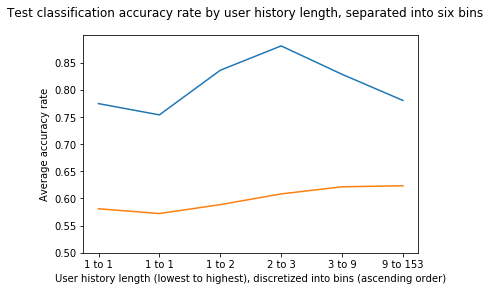

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.614
[1,   400] loss: 0.490
[1,   600] loss: 0.530
[1,   800] loss: 0.423
[1,  1000] loss: 0.564
[1,  1200] loss: 0.487
[1,  1400] loss: 0.425
[1,  1600] loss: 0.442
[1,  1800] loss: 0.449
[1,  2000] loss: 0.434
[1,  2200] loss: 0.485
[1,  2400] loss: 0.438
[1,  2600] loss: 0.461
[1,  2800] loss: 0.440
[1,  3000] loss: 0.424
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.361
[2,   400] loss: 0.272
[2,   600] loss: 0.341
[2,   800] loss: 0.320
[2,  1000] loss: 0.335
[2,  1200] loss: 0.284
[2,  1400] loss: 0.254
[2,  1600] loss: 0.300
[2,  1800] loss: 0.307
[2,  2000] loss: 0.268
[2,  2200] loss: 0.312
[2,  2400] loss: 0.252
[2,  2600] loss: 0.224
[2,  2800] loss: 0.306
[2,  3000] loss: 0.209
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.174
[3,   400] loss: 0.181
[3,   600] loss: 0.214
[3,   800] loss: 0.194
[3,  1000] loss: 0.218
[3,  1200] loss: 0.198
[3,  1400] loss: 0.157
[3,  160

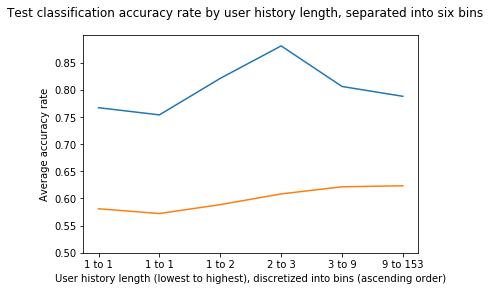

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.610
[1,   400] loss: 0.489
[1,   600] loss: 0.533
[1,   800] loss: 0.421
[1,  1000] loss: 0.567
[1,  1200] loss: 0.492
[1,  1400] loss: 0.429
[1,  1600] loss: 0.443
[1,  1800] loss: 0.445
[1,  2000] loss: 0.431
[1,  2200] loss: 0.488
[1,  2400] loss: 0.448
[1,  2600] loss: 0.463
[1,  2800] loss: 0.438
[1,  3000] loss: 0.426
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.369
[2,   400] loss: 0.281
[2,   600] loss: 0.342
[2,   800] loss: 0.324
[2,  1000] loss: 0.335
[2,  1200] loss: 0.284
[2,  1400] loss: 0.268
[2,  1600] loss: 0.301
[2,  1800] loss: 0.315
[2,  2000] loss: 0.275
[2,  2200] loss: 0.319
[2,  2400] loss: 0.262
[2,  2600] loss: 0.233
[2,  2800] loss: 0.310
[2,  3000] loss: 0.214
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.180
[3,   400] loss: 0.195
[3,   600] loss: 0.222
[3,   800] loss: 0.205
[3,  1000] loss: 0.220
[3,  1200] loss: 0.212
[3,  1400] loss: 0.164
[3,  160

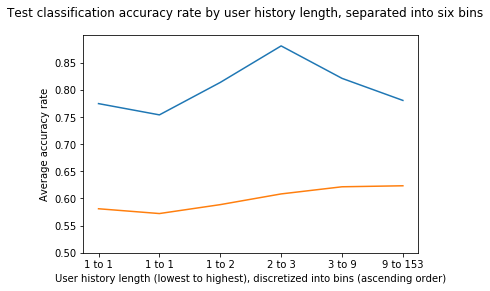

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.606
[1,   400] loss: 0.487
[1,   600] loss: 0.532
[1,   800] loss: 0.424
[1,  1000] loss: 0.564
[1,  1200] loss: 0.493
[1,  1400] loss: 0.422
[1,  1600] loss: 0.438
[1,  1800] loss: 0.451
[1,  2000] loss: 0.430
[1,  2200] loss: 0.488
[1,  2400] loss: 0.441
[1,  2600] loss: 0.463
[1,  2800] loss: 0.436
[1,  3000] loss: 0.427
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.367
[2,   400] loss: 0.270
[2,   600] loss: 0.349
[2,   800] loss: 0.321
[2,  1000] loss: 0.335
[2,  1200] loss: 0.284
[2,  1400] loss: 0.261
[2,  1600] loss: 0.302
[2,  1800] loss: 0.310
[2,  2000] loss: 0.268
[2,  2200] loss: 0.308
[2,  2400] loss: 0.260
[2,  2600] loss: 0.227
[2,  2800] loss: 0.304
[2,  3000] loss: 0.205
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.179
[3,   400] loss: 0.185
[3,   600] loss: 0.226
[3,   800] loss: 0.198
[3,  1000] loss: 0.210
[3,  1200] loss: 0.214
[3,  1400] loss: 0.168
[3,  160

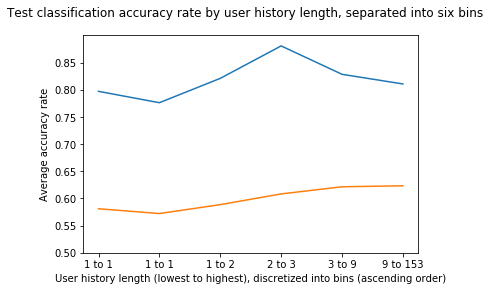

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.606
[1,   400] loss: 0.488
[1,   600] loss: 0.530
[1,   800] loss: 0.420
[1,  1000] loss: 0.563
[1,  1200] loss: 0.494
[1,  1400] loss: 0.427
[1,  1600] loss: 0.440
[1,  1800] loss: 0.446
[1,  2000] loss: 0.432
[1,  2200] loss: 0.484
[1,  2400] loss: 0.440
[1,  2600] loss: 0.463
[1,  2800] loss: 0.439
[1,  3000] loss: 0.430
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.360
[2,   400] loss: 0.275
[2,   600] loss: 0.345
[2,   800] loss: 0.327
[2,  1000] loss: 0.334
[2,  1200] loss: 0.281
[2,  1400] loss: 0.267
[2,  1600] loss: 0.295
[2,  1800] loss: 0.316
[2,  2000] loss: 0.274
[2,  2200] loss: 0.316
[2,  2400] loss: 0.266
[2,  2600] loss: 0.228
[2,  2800] loss: 0.309
[2,  3000] loss: 0.207
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.179
[3,   400] loss: 0.189
[3,   600] loss: 0.233
[3,   800] loss: 0.193
[3,  1000] loss: 0.225
[3,  1200] loss: 0.208
[3,  1400] loss: 0.172
[3,  160

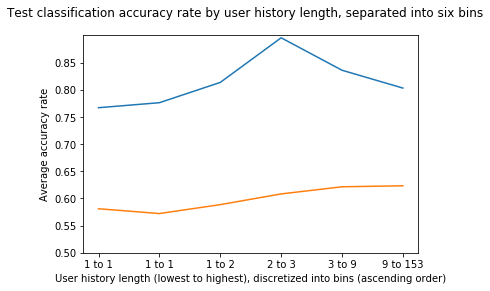

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.609
[1,   400] loss: 0.489
[1,   600] loss: 0.536
[1,   800] loss: 0.420
[1,  1000] loss: 0.564
[1,  1200] loss: 0.492
[1,  1400] loss: 0.427
[1,  1600] loss: 0.436
[1,  1800] loss: 0.447
[1,  2000] loss: 0.429
[1,  2200] loss: 0.488
[1,  2400] loss: 0.446
[1,  2600] loss: 0.461
[1,  2800] loss: 0.438
[1,  3000] loss: 0.425
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.365
[2,   400] loss: 0.282
[2,   600] loss: 0.351
[2,   800] loss: 0.325
[2,  1000] loss: 0.335
[2,  1200] loss: 0.286
[2,  1400] loss: 0.268
[2,  1600] loss: 0.305
[2,  1800] loss: 0.313
[2,  2000] loss: 0.267
[2,  2200] loss: 0.313
[2,  2400] loss: 0.270
[2,  2600] loss: 0.230
[2,  2800] loss: 0.313
[2,  3000] loss: 0.206
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.176
[3,   400] loss: 0.187
[3,   600] loss: 0.232
[3,   800] loss: 0.209
[3,  1000] loss: 0.220
[3,  1200] loss: 0.208
[3,  1400] loss: 0.163
[3,  160

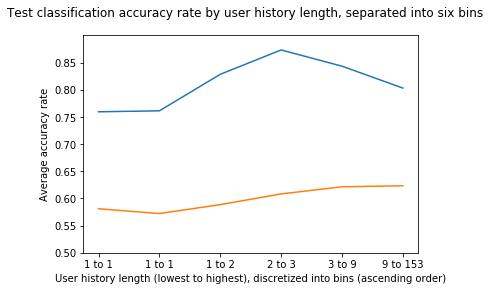

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.610
[1,   400] loss: 0.487
[1,   600] loss: 0.534
[1,   800] loss: 0.422
[1,  1000] loss: 0.567
[1,  1200] loss: 0.494
[1,  1400] loss: 0.430
[1,  1600] loss: 0.439
[1,  1800] loss: 0.447
[1,  2000] loss: 0.430
[1,  2200] loss: 0.486
[1,  2400] loss: 0.444
[1,  2600] loss: 0.465
[1,  2800] loss: 0.438
[1,  3000] loss: 0.426
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.369
[2,   400] loss: 0.280
[2,   600] loss: 0.361
[2,   800] loss: 0.336
[2,  1000] loss: 0.344
[2,  1200] loss: 0.285
[2,  1400] loss: 0.270
[2,  1600] loss: 0.314
[2,  1800] loss: 0.320
[2,  2000] loss: 0.284
[2,  2200] loss: 0.313
[2,  2400] loss: 0.278
[2,  2600] loss: 0.241
[2,  2800] loss: 0.322
[2,  3000] loss: 0.223
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.200
[3,   400] loss: 0.201
[3,   600] loss: 0.247
[3,   800] loss: 0.215
[3,  1000] loss: 0.237
[3,  1200] loss: 0.227
[3,  1400] loss: 0.183
[3,  160

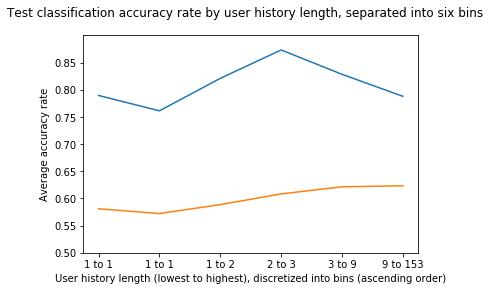

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.605
[1,   400] loss: 0.488
[1,   600] loss: 0.536
[1,   800] loss: 0.422
[1,  1000] loss: 0.566
[1,  1200] loss: 0.494
[1,  1400] loss: 0.431
[1,  1600] loss: 0.436
[1,  1800] loss: 0.450
[1,  2000] loss: 0.433
[1,  2200] loss: 0.487
[1,  2400] loss: 0.442
[1,  2600] loss: 0.457
[1,  2800] loss: 0.439
[1,  3000] loss: 0.432
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.367
[2,   400] loss: 0.276
[2,   600] loss: 0.346
[2,   800] loss: 0.329
[2,  1000] loss: 0.343
[2,  1200] loss: 0.286
[2,  1400] loss: 0.261
[2,  1600] loss: 0.313
[2,  1800] loss: 0.321
[2,  2000] loss: 0.276
[2,  2200] loss: 0.319
[2,  2400] loss: 0.276
[2,  2600] loss: 0.238
[2,  2800] loss: 0.316
[2,  3000] loss: 0.213
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.191
[3,   400] loss: 0.193
[3,   600] loss: 0.231
[3,   800] loss: 0.216
[3,  1000] loss: 0.226
[3,  1200] loss: 0.210
[3,  1400] loss: 0.169
[3,  160

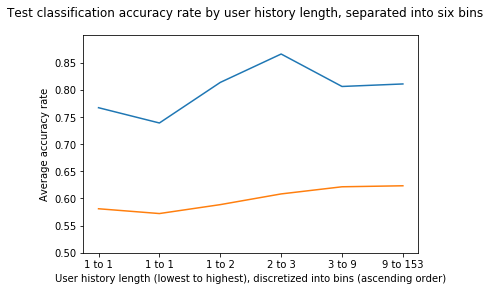

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.602
[1,   400] loss: 0.489
[1,   600] loss: 0.535
[1,   800] loss: 0.420
[1,  1000] loss: 0.563
[1,  1200] loss: 0.493
[1,  1400] loss: 0.428
[1,  1600] loss: 0.435
[1,  1800] loss: 0.449
[1,  2000] loss: 0.432
[1,  2200] loss: 0.486
[1,  2400] loss: 0.444
[1,  2600] loss: 0.460
[1,  2800] loss: 0.441
[1,  3000] loss: 0.424
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.364
[2,   400] loss: 0.271
[2,   600] loss: 0.343
[2,   800] loss: 0.314
[2,  1000] loss: 0.335
[2,  1200] loss: 0.283
[2,  1400] loss: 0.256
[2,  1600] loss: 0.293
[2,  1800] loss: 0.309
[2,  2000] loss: 0.269
[2,  2200] loss: 0.309
[2,  2400] loss: 0.255
[2,  2600] loss: 0.234
[2,  2800] loss: 0.297
[2,  3000] loss: 0.200
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.176
[3,   400] loss: 0.181
[3,   600] loss: 0.218
[3,   800] loss: 0.200
[3,  1000] loss: 0.213
[3,  1200] loss: 0.201
[3,  1400] loss: 0.158
[3,  160

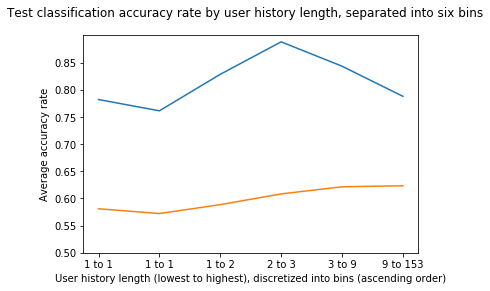

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.604
[1,   400] loss: 0.492
[1,   600] loss: 0.534
[1,   800] loss: 0.421
[1,  1000] loss: 0.561
[1,  1200] loss: 0.495
[1,  1400] loss: 0.428
[1,  1600] loss: 0.435
[1,  1800] loss: 0.446
[1,  2000] loss: 0.433
[1,  2200] loss: 0.489
[1,  2400] loss: 0.447
[1,  2600] loss: 0.458
[1,  2800] loss: 0.438
[1,  3000] loss: 0.423
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.360
[2,   400] loss: 0.268
[2,   600] loss: 0.333
[2,   800] loss: 0.320
[2,  1000] loss: 0.334
[2,  1200] loss: 0.273
[2,  1400] loss: 0.248
[2,  1600] loss: 0.301
[2,  1800] loss: 0.306
[2,  2000] loss: 0.266
[2,  2200] loss: 0.310
[2,  2400] loss: 0.249
[2,  2600] loss: 0.228
[2,  2800] loss: 0.303
[2,  3000] loss: 0.205
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.167
[3,   400] loss: 0.173
[3,   600] loss: 0.215
[3,   800] loss: 0.190
[3,  1000] loss: 0.210
[3,  1200] loss: 0.192
[3,  1400] loss: 0.154
[3,  160

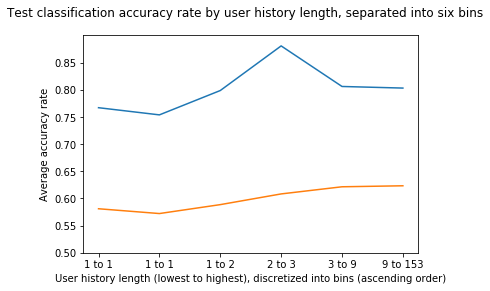

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.612
[1,   400] loss: 0.492
[1,   600] loss: 0.529
[1,   800] loss: 0.416
[1,  1000] loss: 0.568
[1,  1200] loss: 0.497
[1,  1400] loss: 0.427
[1,  1600] loss: 0.439
[1,  1800] loss: 0.450
[1,  2000] loss: 0.433
[1,  2200] loss: 0.489
[1,  2400] loss: 0.444
[1,  2600] loss: 0.462
[1,  2800] loss: 0.438
[1,  3000] loss: 0.425
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.366
[2,   400] loss: 0.280
[2,   600] loss: 0.350
[2,   800] loss: 0.331
[2,  1000] loss: 0.343
[2,  1200] loss: 0.289
[2,  1400] loss: 0.275
[2,  1600] loss: 0.316
[2,  1800] loss: 0.320
[2,  2000] loss: 0.279
[2,  2200] loss: 0.321
[2,  2400] loss: 0.272
[2,  2600] loss: 0.239
[2,  2800] loss: 0.308
[2,  3000] loss: 0.225
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.194
[3,   400] loss: 0.196
[3,   600] loss: 0.237
[3,   800] loss: 0.217
[3,  1000] loss: 0.228
[3,  1200] loss: 0.223
[3,  1400] loss: 0.186
[3,  160

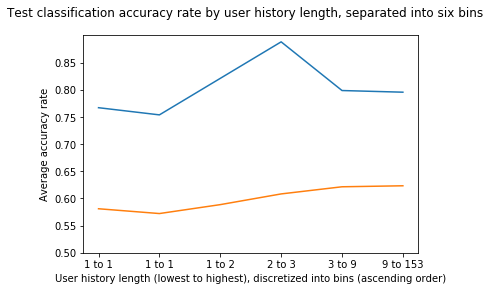

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.610
[1,   400] loss: 0.488
[1,   600] loss: 0.536
[1,   800] loss: 0.420
[1,  1000] loss: 0.563
[1,  1200] loss: 0.493
[1,  1400] loss: 0.427
[1,  1600] loss: 0.437
[1,  1800] loss: 0.446
[1,  2000] loss: 0.434
[1,  2200] loss: 0.489
[1,  2400] loss: 0.445
[1,  2600] loss: 0.461
[1,  2800] loss: 0.438
[1,  3000] loss: 0.424
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.367
[2,   400] loss: 0.278
[2,   600] loss: 0.355
[2,   800] loss: 0.328
[2,  1000] loss: 0.342
[2,  1200] loss: 0.286
[2,  1400] loss: 0.269
[2,  1600] loss: 0.313
[2,  1800] loss: 0.320
[2,  2000] loss: 0.275
[2,  2200] loss: 0.319
[2,  2400] loss: 0.264
[2,  2600] loss: 0.233
[2,  2800] loss: 0.310
[2,  3000] loss: 0.213
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.185
[3,   400] loss: 0.193
[3,   600] loss: 0.238
[3,   800] loss: 0.208
[3,  1000] loss: 0.228
[3,  1200] loss: 0.213
[3,  1400] loss: 0.168
[3,  160

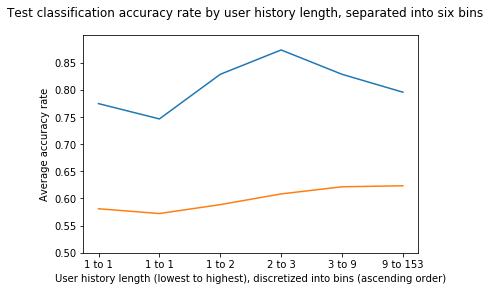

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.608
[1,   400] loss: 0.489
[1,   600] loss: 0.530
[1,   800] loss: 0.421
[1,  1000] loss: 0.566
[1,  1200] loss: 0.492
[1,  1400] loss: 0.430
[1,  1600] loss: 0.443
[1,  1800] loss: 0.448
[1,  2000] loss: 0.433
[1,  2200] loss: 0.483
[1,  2400] loss: 0.442
[1,  2600] loss: 0.457
[1,  2800] loss: 0.440
[1,  3000] loss: 0.421
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.358
[2,   400] loss: 0.274
[2,   600] loss: 0.340
[2,   800] loss: 0.323
[2,  1000] loss: 0.334
[2,  1200] loss: 0.281
[2,  1400] loss: 0.262
[2,  1600] loss: 0.301
[2,  1800] loss: 0.317
[2,  2000] loss: 0.270
[2,  2200] loss: 0.303
[2,  2400] loss: 0.262
[2,  2600] loss: 0.229
[2,  2800] loss: 0.305
[2,  3000] loss: 0.208
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.171
[3,   400] loss: 0.183
[3,   600] loss: 0.229
[3,   800] loss: 0.203
[3,  1000] loss: 0.224
[3,  1200] loss: 0.200
[3,  1400] loss: 0.161
[3,  160

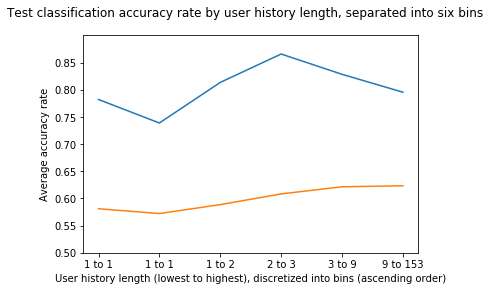

epoch: 0 learning rate: [0.01418295487782988]
[1,   200] loss: 0.607
[1,   400] loss: 0.487
[1,   600] loss: 0.535
[1,   800] loss: 0.420
[1,  1000] loss: 0.567
[1,  1200] loss: 0.495
[1,  1400] loss: 0.424
[1,  1600] loss: 0.441
[1,  1800] loss: 0.447
[1,  2000] loss: 0.431
[1,  2200] loss: 0.486
[1,  2400] loss: 0.441
[1,  2600] loss: 0.458
[1,  2800] loss: 0.438
[1,  3000] loss: 0.431
epoch: 1 learning rate: [0.002475130784942712]
[2,   200] loss: 0.361
[2,   400] loss: 0.274
[2,   600] loss: 0.343
[2,   800] loss: 0.324
[2,  1000] loss: 0.338
[2,  1200] loss: 0.277
[2,  1400] loss: 0.264
[2,  1600] loss: 0.305
[2,  1800] loss: 0.309
[2,  2000] loss: 0.269
[2,  2200] loss: 0.313
[2,  2400] loss: 0.262
[2,  2600] loss: 0.228
[2,  2800] loss: 0.302
[2,  3000] loss: 0.206
epoch: 2 learning rate: [0.0004319461251440221]
[3,   200] loss: 0.181
[3,   400] loss: 0.183
[3,   600] loss: 0.226
[3,   800] loss: 0.200
[3,  1000] loss: 0.219
[3,  1200] loss: 0.210
[3,  1400] loss: 0.163
[3,  160

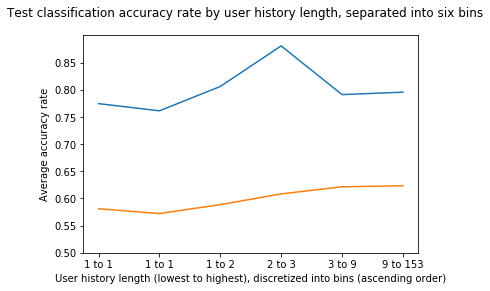

In [5]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_img_train, X_img_test)

Acc: 0.8059925093632958
AUC: 0.850957909560319
F1: 0.8718516287778278
Precision: 0.8368958901190636
Recall: 0.9098795180722891


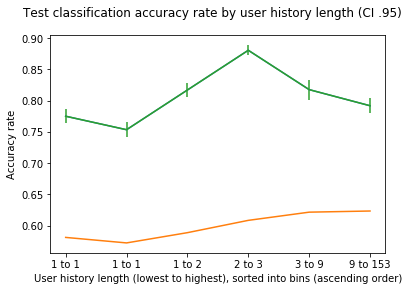

In [6]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [7]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [8]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'history_baseline_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [9]:
# retieve test data history sequence lengths from LSTM data
X_hist_len_test = np.load(NPY_INPUT_DIR + 'full_hist_lens_test.npy')

# class labels
y_train = np.load(GLOVE_DIR + 'y_train.npy')
y_test= np.load(GLOVE_DIR + 'y_test.npy')

# load features
# img
X_histories_train_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_train.npy')
X_histories_test_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_test.npy')

X_labeled_train_img = np.load(NPY_INPUT_DIR + 'images_nohistories_train.npy')
X_labeled_test_img = np.load(NPY_INPUT_DIR + 'images_nohistories_test.npy')

# lang
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')



X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')


scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

scaler5 = StandardScaler()
scaler6 = StandardScaler()


X_histories_train_img_norm = scaler5.fit_transform(X_histories_train_img)
X_histories_test_img_norm  = scaler5.transform(X_histories_test_img)
X_labeled_train_img_norm = scaler5.fit_transform(X_labeled_train_img)
X_labeled_test_img_norm  = scaler5.transform(X_labeled_test_img)
        
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)


epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.557
[1,   400] loss: 0.488
[1,   600] loss: 0.465
[1,   800] loss: 0.405
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.334
[2,   400] loss: 0.317
[2,   600] loss: 0.314
[2,   800] loss: 0.338
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.281
[3,   400] loss: 0.293
[3,   600] loss: 0.288
[3,   800] loss: 0.283
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

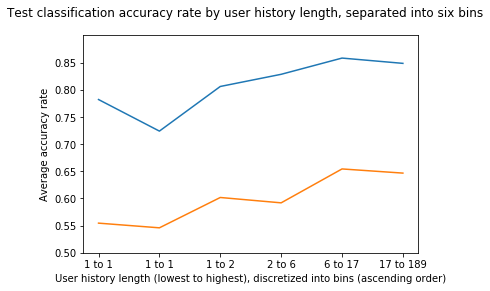

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.526
[1,   400] loss: 0.476
[1,   600] loss: 0.442
[1,   800] loss: 0.468
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.321
[2,   400] loss: 0.335
[2,   600] loss: 0.315
[2,   800] loss: 0.330
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.292
[3,   400] loss: 0.275
[3,   600] loss: 0.263
[3,   800] loss: 0.311
R2 score for bin 0 = 0.230843373493976
R2 score for bin 1 = -0.3421849522478453
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.83

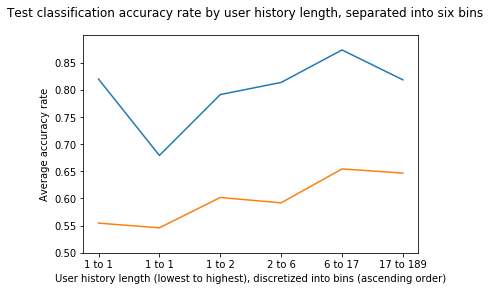

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.540
[1,   400] loss: 0.467
[1,   600] loss: 0.449
[1,   800] loss: 0.457
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.352
[2,   400] loss: 0.347
[2,   600] loss: 0.297
[2,   800] loss: 0.326
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.330
[3,   400] loss: 0.278
[3,   600] loss: 0.263
[3,   800] loss: 0.285
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 

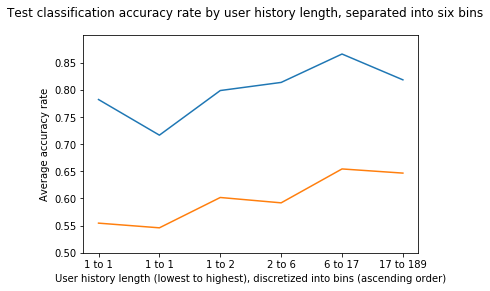

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.548
[1,   400] loss: 0.482
[1,   600] loss: 0.433
[1,   800] loss: 0.446
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.331
[2,   400] loss: 0.338
[2,   600] loss: 0.329
[2,   800] loss: 0.321
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.295
[3,   400] loss: 0.306
[3,   600] loss: 0.268
[3,   800] loss: 0.288
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0

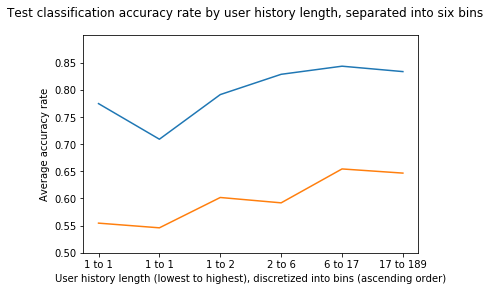

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.562
[1,   400] loss: 0.480
[1,   600] loss: 0.459
[1,   800] loss: 0.433
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.333
[2,   400] loss: 0.329
[2,   600] loss: 0.333
[2,   800] loss: 0.322
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.270
[3,   400] loss: 0.286
[3,   600] loss: 0.290
[3,   800] loss: 0.308
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

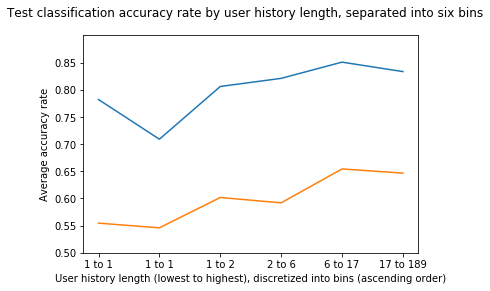

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.567
[1,   400] loss: 0.525
[1,   600] loss: 0.410
[1,   800] loss: 0.417
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.342
[2,   400] loss: 0.309
[2,   600] loss: 0.341
[2,   800] loss: 0.333
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.292
[3,   400] loss: 0.287
[3,   600] loss: 0.292
[3,   800] loss: 0.283
R2 score for bin 0 = -0.0896385542168674
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.036363636363636154
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8

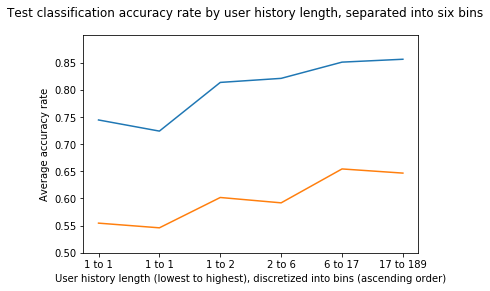

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.551
[1,   400] loss: 0.487
[1,   600] loss: 0.438
[1,   800] loss: 0.450
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.318
[2,   400] loss: 0.340
[2,   600] loss: 0.309
[2,   800] loss: 0.349
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.302
[3,   400] loss: 0.289
[3,   600] loss: 0.285
[3,   800] loss: 0.283
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0

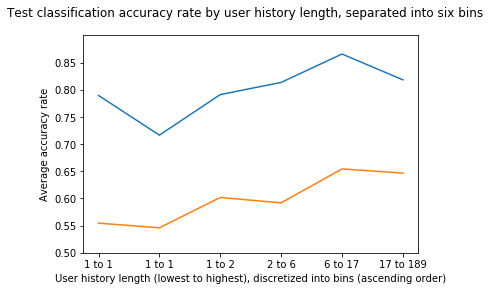

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.568
[1,   400] loss: 0.451
[1,   600] loss: 0.443
[1,   800] loss: 0.464
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.332
[2,   400] loss: 0.346
[2,   600] loss: 0.321
[2,   800] loss: 0.329
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.292
[3,   400] loss: 0.312
[3,   600] loss: 0.288
[3,   800] loss: 0.273
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 

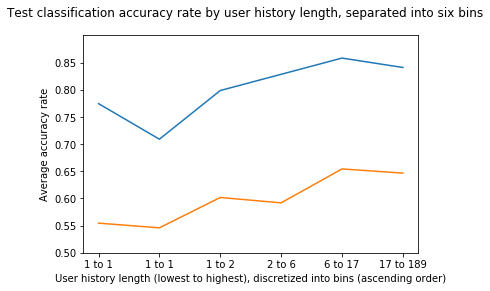

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.536
[1,   400] loss: 0.494
[1,   600] loss: 0.440
[1,   800] loss: 0.443
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.364
[2,   400] loss: 0.341
[2,   600] loss: 0.306
[2,   800] loss: 0.296
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.294
[3,   400] loss: 0.293
[3,   600] loss: 0.264
[3,   800] loss: 0.295
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 =

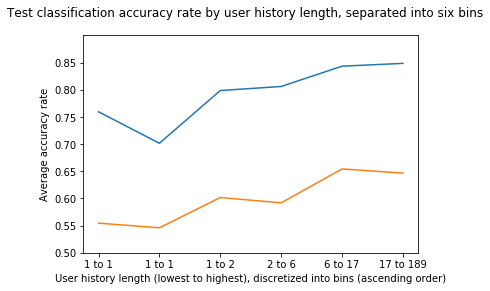

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.568
[1,   400] loss: 0.458
[1,   600] loss: 0.453
[1,   800] loss: 0.428
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.341
[2,   400] loss: 0.335
[2,   600] loss: 0.318
[2,   800] loss: 0.316
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.268
[3,   400] loss: 0.297
[3,   600] loss: 0.296
[3,   800] loss: 0.284
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 

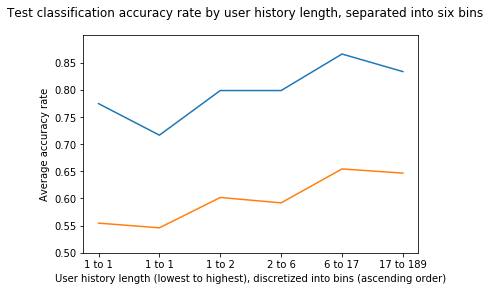

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.542
[1,   400] loss: 0.450
[1,   600] loss: 0.436
[1,   800] loss: 0.467
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.336
[2,   400] loss: 0.330
[2,   600] loss: 0.342
[2,   800] loss: 0.302
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.296
[3,   400] loss: 0.282
[3,   600] loss: 0.290
[3,   800] loss: 0.269
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.2929824561403511
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

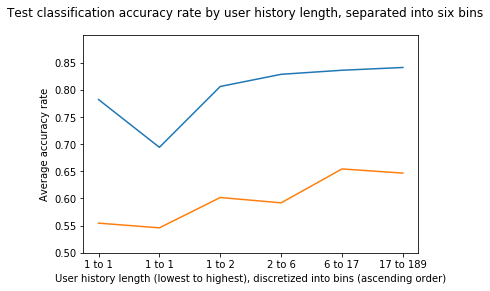

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.550
[1,   400] loss: 0.465
[1,   600] loss: 0.453
[1,   800] loss: 0.441
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.344
[2,   400] loss: 0.322
[2,   600] loss: 0.324
[2,   800] loss: 0.348
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.287
[3,   400] loss: 0.290
[3,   600] loss: 0.303
[3,   800] loss: 0.295
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = 0.08843537414965985
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8

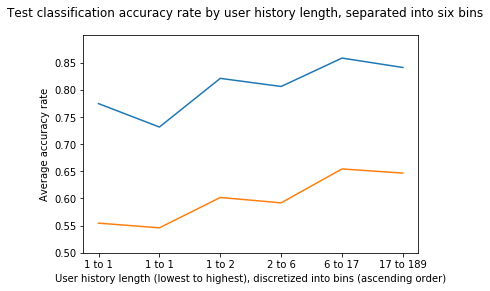

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.536
[1,   400] loss: 0.434
[1,   600] loss: 0.466
[1,   800] loss: 0.469
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.334
[2,   400] loss: 0.302
[2,   600] loss: 0.338
[2,   800] loss: 0.337
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.297
[3,   400] loss: 0.276
[3,   600] loss: 0.296
[3,   800] loss: 0.268
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0

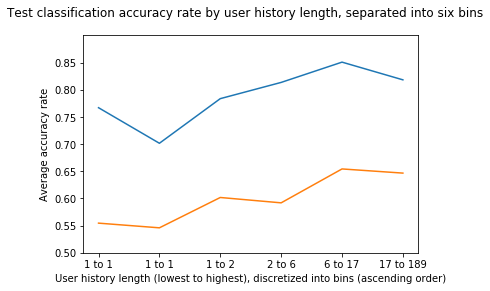

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.570
[1,   400] loss: 0.452
[1,   600] loss: 0.424
[1,   800] loss: 0.471
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.348
[2,   400] loss: 0.321
[2,   600] loss: 0.320
[2,   800] loss: 0.312
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.265
[3,   400] loss: 0.295
[3,   600] loss: 0.287
[3,   800] loss: 0.285
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

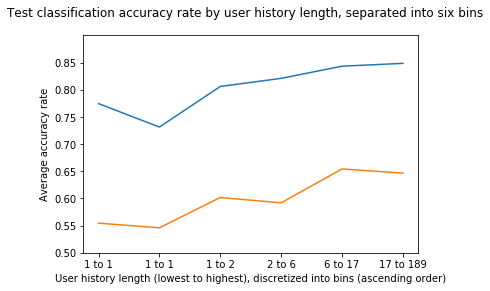

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.568
[1,   400] loss: 0.464
[1,   600] loss: 0.421
[1,   800] loss: 0.460
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.319
[2,   400] loss: 0.359
[2,   600] loss: 0.329
[2,   800] loss: 0.320
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.304
[3,   400] loss: 0.269
[3,   600] loss: 0.310
[3,   800] loss: 0.279
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = 0.16439909297052147
R2 score for bin 3 = -0.012685560053981249
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

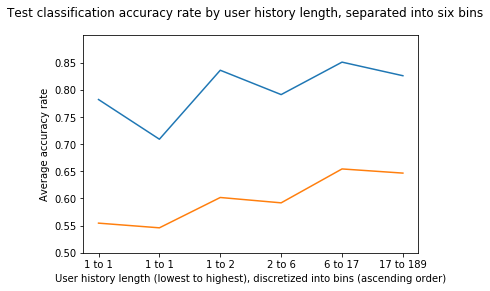

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.557
[1,   400] loss: 0.478
[1,   600] loss: 0.435
[1,   800] loss: 0.438
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.319
[2,   400] loss: 0.335
[2,   600] loss: 0.322
[2,   800] loss: 0.333
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.271
[3,   400] loss: 0.329
[3,   600] loss: 0.268
[3,   800] loss: 0.278
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.3517543859649126
R2 score for bin 5 = -0.36363636363636354
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

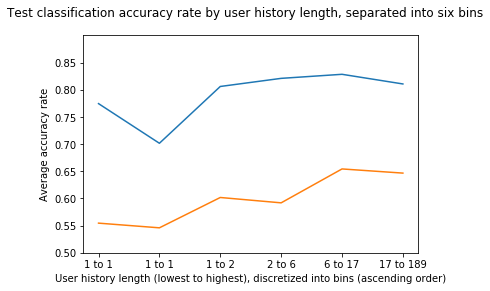

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.549
[1,   400] loss: 0.499
[1,   600] loss: 0.455
[1,   800] loss: 0.421
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.321
[2,   400] loss: 0.314
[2,   600] loss: 0.344
[2,   800] loss: 0.324
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.280
[3,   400] loss: 0.256
[3,   600] loss: 0.290
[3,   800] loss: 0.312
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0

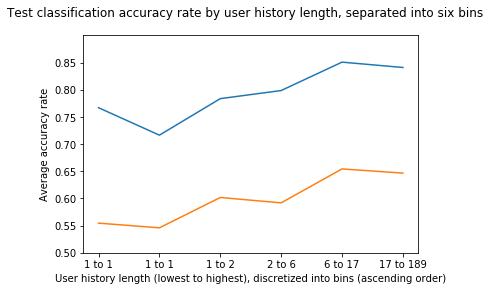

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.564
[1,   400] loss: 0.461
[1,   600] loss: 0.452
[1,   800] loss: 0.436
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.331
[2,   400] loss: 0.312
[2,   600] loss: 0.347
[2,   800] loss: 0.343
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.315
[3,   400] loss: 0.281
[3,   600] loss: 0.298
[3,   800] loss: 0.280
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.08843537414965985
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

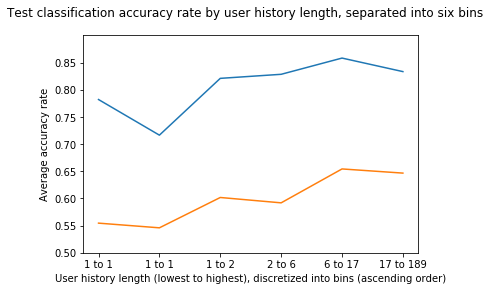

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.551
[1,   400] loss: 0.488
[1,   600] loss: 0.437
[1,   800] loss: 0.427
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.345
[2,   400] loss: 0.338
[2,   600] loss: 0.355
[2,   800] loss: 0.311
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.305
[3,   400] loss: 0.305
[3,   600] loss: 0.288
[3,   800] loss: 0.286
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.0924761239226648
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

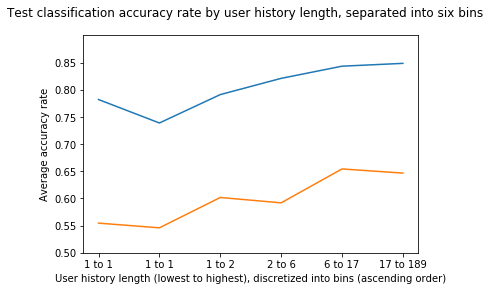

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.551
[1,   400] loss: 0.475
[1,   600] loss: 0.462
[1,   800] loss: 0.416
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.354
[2,   400] loss: 0.338
[2,   600] loss: 0.303
[2,   800] loss: 0.305
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.267
[3,   400] loss: 0.279
[3,   600] loss: 0.317
[3,   800] loss: 0.268
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0

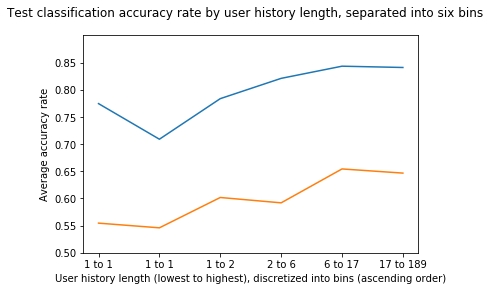

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.568
[1,   400] loss: 0.468
[1,   600] loss: 0.438
[1,   800] loss: 0.443
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.316
[2,   400] loss: 0.350
[2,   600] loss: 0.348
[2,   800] loss: 0.320
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.310
[3,   400] loss: 0.280
[3,   600] loss: 0.289
[3,   800] loss: 0.297
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8

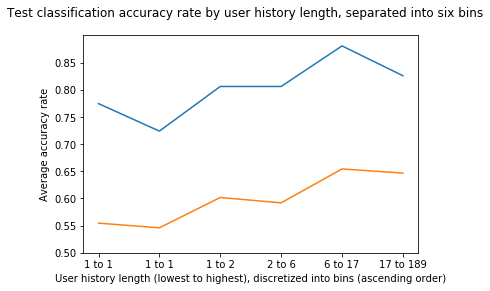

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.544
[1,   400] loss: 0.483
[1,   600] loss: 0.445
[1,   800] loss: 0.465
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.361
[2,   400] loss: 0.324
[2,   600] loss: 0.319
[2,   800] loss: 0.314
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.288
[3,   400] loss: 0.286
[3,   600] loss: 0.273
[3,   800] loss: 0.311
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0

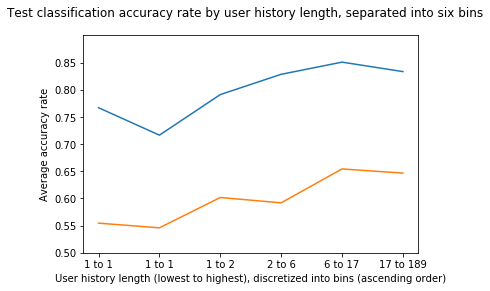

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.562
[1,   400] loss: 0.455
[1,   600] loss: 0.463
[1,   800] loss: 0.460
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.343
[2,   400] loss: 0.318
[2,   600] loss: 0.311
[2,   800] loss: 0.336
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.280
[3,   400] loss: 0.314
[3,   600] loss: 0.266
[3,   800] loss: 0.285
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0

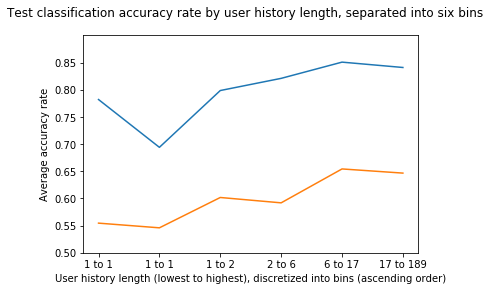

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.533
[1,   400] loss: 0.451
[1,   600] loss: 0.451
[1,   800] loss: 0.491
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.341
[2,   400] loss: 0.324
[2,   600] loss: 0.318
[2,   800] loss: 0.344
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.295
[3,   400] loss: 0.299
[3,   600] loss: 0.288
[3,   800] loss: 0.286
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.

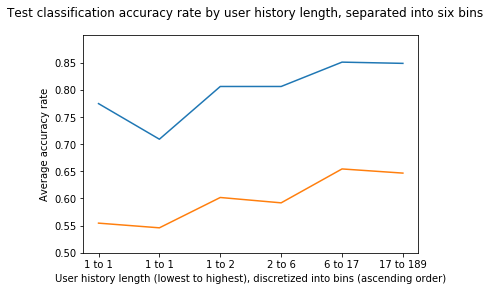

epoch: 0 learning rate: [0.009526187612921844]
[1,   200] loss: 0.529
[1,   400] loss: 0.474
[1,   600] loss: 0.474
[1,   800] loss: 0.440
epoch: 1 learning rate: [0.0015057666165343181]
[2,   200] loss: 0.327
[2,   400] loss: 0.323
[2,   600] loss: 0.326
[2,   800] loss: 0.329
epoch: 2 learning rate: [0.00023801054478432413]
[3,   200] loss: 0.280
[3,   400] loss: 0.276
[3,   600] loss: 0.285
[3,   800] loss: 0.297
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 

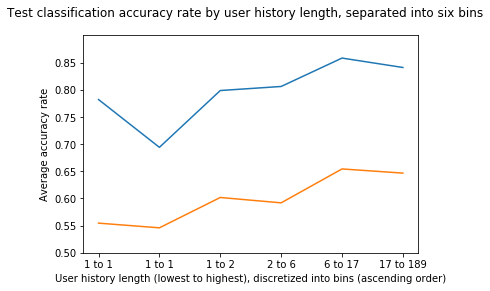

In [10]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.7989013732833957
AUC: 0.8386662494132372
F1: 0.8683491739332296
Precision: 0.8268053287363593
Recall: 0.914354561101549


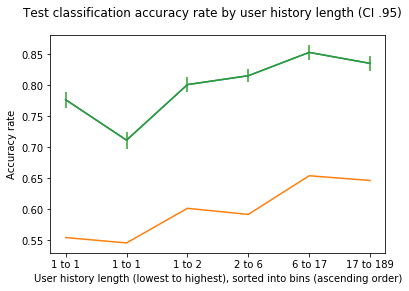

In [11]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [12]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'nohistory_baseline_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [13]:
# merge data

# merge data
X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                      X_labeled_train_img_norm),
                     axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                     X_labeled_test_img_norm),
                    axis = 1)

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.654
[1,   400] loss: 0.615
[1,   600] loss: 0.544
[1,   800] loss: 0.533
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.414
[2,   400] loss: 0.422
[2,   600] loss: 0.415
[2,   800] loss: 0.412
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.366
[3,   400] loss: 0.376
[3,   600] loss: 0.338
[3,   800] loss: 0.383
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.345
[4,   400] loss: 0.329
[4,   600] loss: 0.346
[4,   800] loss: 0.370
R2 score for bin 0 = -0.0896385542168674
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + 

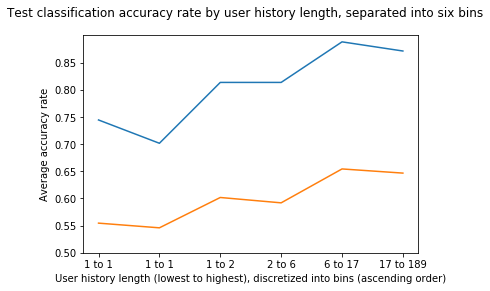

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.634
[1,   400] loss: 0.616
[1,   600] loss: 0.522
[1,   800] loss: 0.541
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.456
[2,   400] loss: 0.398
[2,   600] loss: 0.435
[2,   800] loss: 0.395
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.344
[3,   400] loss: 0.356
[3,   600] loss: 0.368
[3,   800] loss: 0.371
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.351
[4,   400] loss: 0.346
[4,   600] loss: 0.337
[4,   800] loss: 0.339
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.06126252038201718
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = 0.12727272727272743
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of 

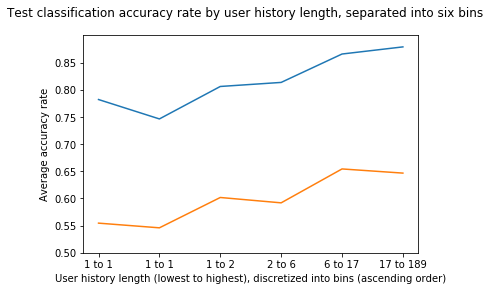

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.685
[1,   400] loss: 0.693
[1,   600] loss: 0.495
[1,   800] loss: 0.511
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.437
[2,   400] loss: 0.407
[2,   600] loss: 0.399
[2,   800] loss: 0.377
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.364
[3,   400] loss: 0.364
[3,   600] loss: 0.340
[3,   800] loss: 0.374
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.347
[4,   400] loss: 0.324
[4,   600] loss: 0.346
[4,   800] loss: 0.347
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.12727272727272743
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

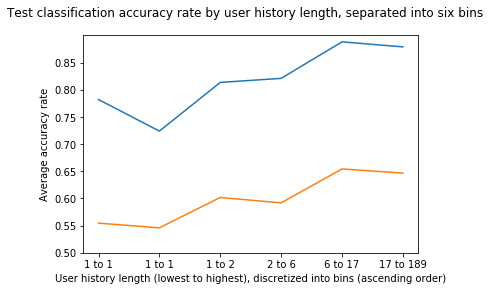

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.650
[1,   400] loss: 0.641
[1,   600] loss: 0.561
[1,   800] loss: 0.501
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.408
[2,   400] loss: 0.395
[2,   600] loss: 0.385
[2,   800] loss: 0.418
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.327
[3,   400] loss: 0.364
[3,   600] loss: 0.383
[3,   800] loss: 0.341
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.333
[4,   400] loss: 0.328
[4,   600] loss: 0.339
[4,   800] loss: 0.343
R2 score for bin 0 = 0.1987951807228916
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + 

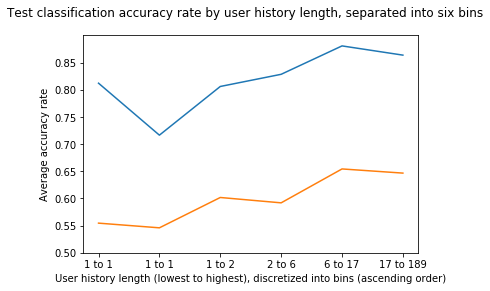

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.671
[1,   400] loss: 0.610
[1,   600] loss: 0.558
[1,   800] loss: 0.492
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.379
[2,   400] loss: 0.417
[2,   600] loss: 0.409
[2,   800] loss: 0.415
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.349
[3,   400] loss: 0.339
[3,   600] loss: 0.373
[3,   800] loss: 0.359
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.308
[4,   400] loss: 0.332
[4,   600] loss: 0.374
[4,   800] loss: 0.338
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.06126252038201718
R2 score for bin 2 = 0.16439909297052147
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

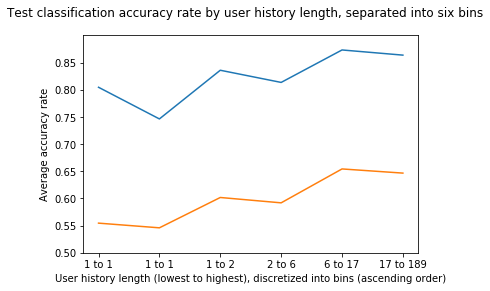

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.710
[1,   400] loss: 0.582
[1,   600] loss: 0.604
[1,   800] loss: 0.495
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.424
[2,   400] loss: 0.419
[2,   600] loss: 0.411
[2,   800] loss: 0.417
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.392
[3,   400] loss: 0.342
[3,   600] loss: 0.346
[3,   800] loss: 0.376
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.369
[4,   400] loss: 0.353
[4,   600] loss: 0.331
[4,   800] loss: 0.329
R2 score for bin 0 = -0.05759036144578311
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.1264172335600907
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.12727272727272743
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

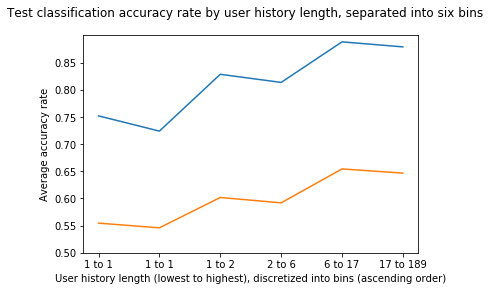

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.660
[1,   400] loss: 0.601
[1,   600] loss: 0.562
[1,   800] loss: 0.469
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.408
[2,   400] loss: 0.399
[2,   600] loss: 0.403
[2,   800] loss: 0.398
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.342
[3,   400] loss: 0.373
[3,   600] loss: 0.356
[3,   800] loss: 0.356
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.347
[4,   400] loss: 0.339
[4,   600] loss: 0.321
[4,   800] loss: 0.344
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.030048916841369566
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of +

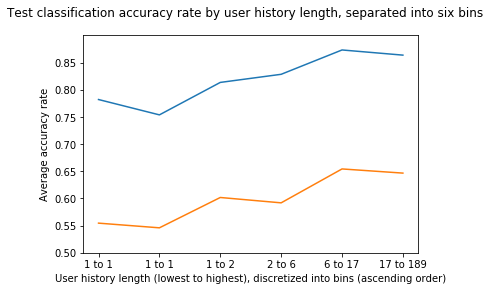

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.703
[1,   400] loss: 0.610
[1,   600] loss: 0.576
[1,   800] loss: 0.517
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.430
[2,   400] loss: 0.434
[2,   600] loss: 0.412
[2,   800] loss: 0.411
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.376
[3,   400] loss: 0.375
[3,   600] loss: 0.346
[3,   800] loss: 0.390
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.355
[4,   400] loss: 0.358
[4,   600] loss: 0.364
[4,   800] loss: 0.332
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.0924761239226648
R2 score for bin 2 = 0.08843537414965985
R2 score for bin 3 = 0.2043184885290148
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = 0.12727272727272743
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + sc

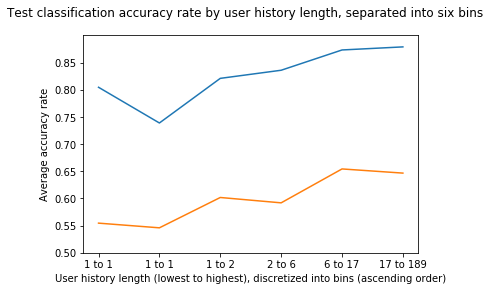

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.727
[1,   400] loss: 0.600
[1,   600] loss: 0.550
[1,   800] loss: 0.524
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.436
[2,   400] loss: 0.371
[2,   600] loss: 0.416
[2,   800] loss: 0.413
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.360
[3,   400] loss: 0.354
[3,   600] loss: 0.356
[3,   800] loss: 0.344
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.334
[4,   400] loss: 0.320
[4,   600] loss: 0.330
[4,   800] loss: 0.357
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = 0.0011646866992779392
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.2043184885290148
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of +

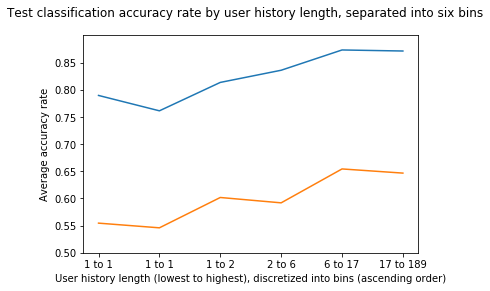

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.647
[1,   400] loss: 0.663
[1,   600] loss: 0.570
[1,   800] loss: 0.518
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.440
[2,   400] loss: 0.403
[2,   600] loss: 0.414
[2,   800] loss: 0.404
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.356
[3,   400] loss: 0.396
[3,   600] loss: 0.359
[3,   800] loss: 0.332
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.363
[4,   400] loss: 0.332
[4,   600] loss: 0.342
[4,   800] loss: 0.347
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.0924761239226648
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = 0.18181818181818188
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + 

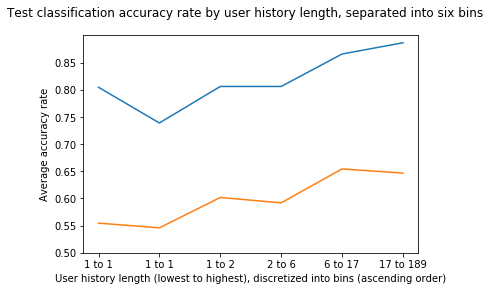

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.660
[1,   400] loss: 0.652
[1,   600] loss: 0.615
[1,   800] loss: 0.504
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.429
[2,   400] loss: 0.443
[2,   600] loss: 0.358
[2,   800] loss: 0.399
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.365
[3,   400] loss: 0.344
[3,   600] loss: 0.343
[3,   800] loss: 0.364
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.348
[4,   400] loss: 0.346
[4,   600] loss: 0.331
[4,   800] loss: 0.317
R2 score for bin 0 = 0.13469879518072292
R2 score for bin 1 = 0.06359189378057306
R2 score for bin 2 = 0.20238095238095233
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

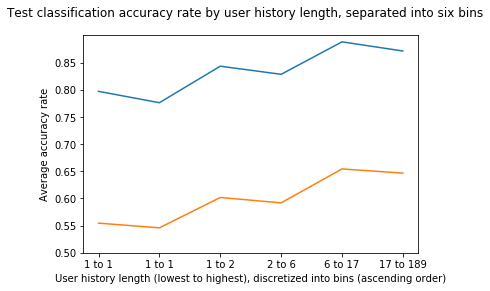

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.641
[1,   400] loss: 0.619
[1,   600] loss: 0.528
[1,   800] loss: 0.513
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.412
[2,   400] loss: 0.414
[2,   600] loss: 0.375
[2,   800] loss: 0.424
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.352
[3,   400] loss: 0.367
[3,   600] loss: 0.345
[3,   800] loss: 0.384
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.330
[4,   400] loss: 0.351
[4,   600] loss: 0.336
[4,   800] loss: 0.354
R2 score for bin 0 = 0.1987951807228916
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of +

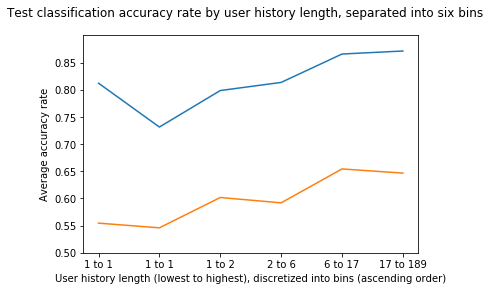

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.682
[1,   400] loss: 0.617
[1,   600] loss: 0.596
[1,   800] loss: 0.524
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.435
[2,   400] loss: 0.398
[2,   600] loss: 0.403
[2,   800] loss: 0.402
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.351
[3,   400] loss: 0.376
[3,   600] loss: 0.364
[3,   800] loss: 0.342
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.347
[4,   400] loss: 0.325
[4,   600] loss: 0.361
[4,   800] loss: 0.328
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = 0.1264172335600907
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + 

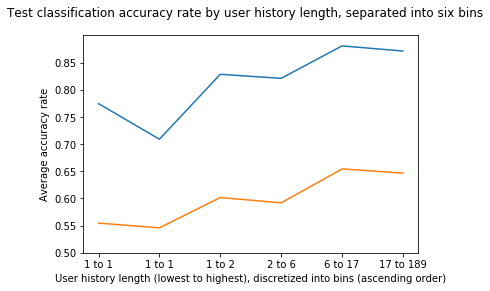

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.687
[1,   400] loss: 0.659
[1,   600] loss: 0.554
[1,   800] loss: 0.515
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.458
[2,   400] loss: 0.396
[2,   600] loss: 0.396
[2,   800] loss: 0.406
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.382
[3,   400] loss: 0.362
[3,   600] loss: 0.362
[3,   800] loss: 0.352
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.327
[4,   400] loss: 0.353
[4,   600] loss: 0.337
[4,   800] loss: 0.372
R2 score for bin 0 = -0.12168674698795168
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = -0.012685560053981249
R2 score for bin 4 = 0.17719298245614024
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of

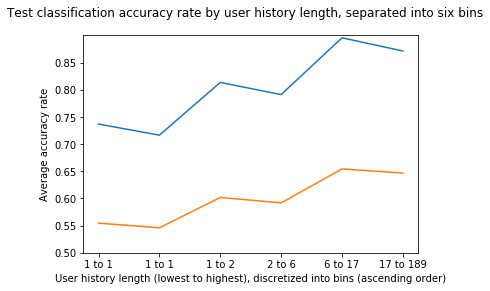

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.668
[1,   400] loss: 0.598
[1,   600] loss: 0.576
[1,   800] loss: 0.500
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.450
[2,   400] loss: 0.391
[2,   600] loss: 0.420
[2,   800] loss: 0.385
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.347
[3,   400] loss: 0.359
[3,   600] loss: 0.389
[3,   800] loss: 0.326
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.334
[4,   400] loss: 0.333
[4,   600] loss: 0.348
[4,   800] loss: 0.343
R2 score for bin 0 = 0.13469879518072292
R2 score for bin 1 = -0.0924761239226648
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = 0.18181818181818188
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + 

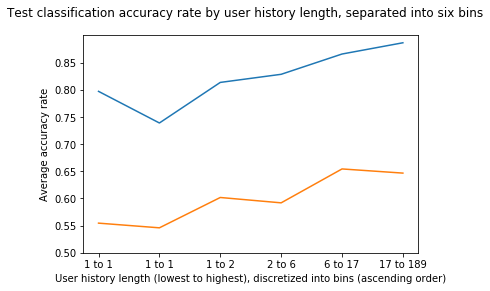

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.644
[1,   400] loss: 0.609
[1,   600] loss: 0.542
[1,   800] loss: 0.531
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.409
[2,   400] loss: 0.411
[2,   600] loss: 0.410
[2,   800] loss: 0.410
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.353
[3,   400] loss: 0.351
[3,   600] loss: 0.396
[3,   800] loss: 0.340
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.348
[4,   400] loss: 0.322
[4,   600] loss: 0.339
[4,   800] loss: 0.368
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = 0.16439909297052147
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.12727272727272743
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

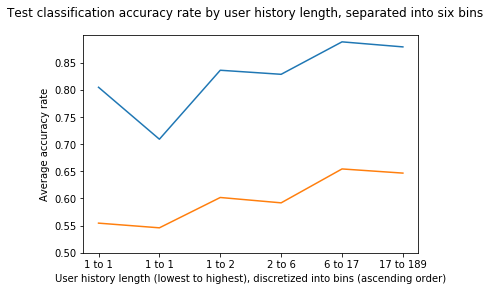

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.622
[1,   400] loss: 0.628
[1,   600] loss: 0.544
[1,   800] loss: 0.504
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.426
[2,   400] loss: 0.413
[2,   600] loss: 0.426
[2,   800] loss: 0.386
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.354
[3,   400] loss: 0.355
[3,   600] loss: 0.361
[3,   800] loss: 0.356
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.308
[4,   400] loss: 0.342
[4,   600] loss: 0.345
[4,   800] loss: 0.360
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = 0.1264172335600907
R2 score for bin 3 = 0.2043184885290148
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scor

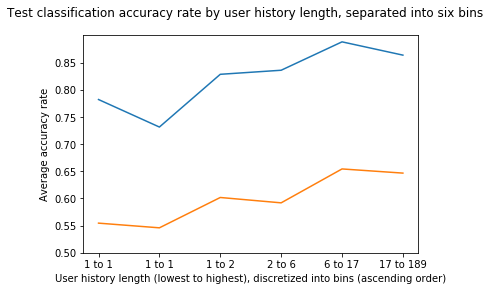

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.703
[1,   400] loss: 0.632
[1,   600] loss: 0.536
[1,   800] loss: 0.510
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.441
[2,   400] loss: 0.419
[2,   600] loss: 0.394
[2,   800] loss: 0.388
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.367
[3,   400] loss: 0.361
[3,   600] loss: 0.349
[3,   800] loss: 0.348
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.335
[4,   400] loss: 0.320
[4,   600] loss: 0.359
[4,   800] loss: 0.343
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.08843537414965985
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = 0.12727272727272743
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

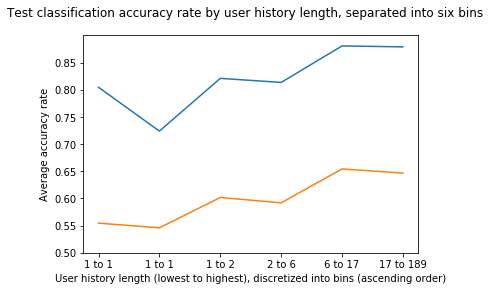

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.667
[1,   400] loss: 0.705
[1,   600] loss: 0.554
[1,   800] loss: 0.486
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.432
[2,   400] loss: 0.397
[2,   600] loss: 0.397
[2,   800] loss: 0.408
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.361
[3,   400] loss: 0.376
[3,   600] loss: 0.333
[3,   800] loss: 0.366
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.359
[4,   400] loss: 0.325
[4,   600] loss: 0.355
[4,   800] loss: 0.327
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.23636363636363644
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + 

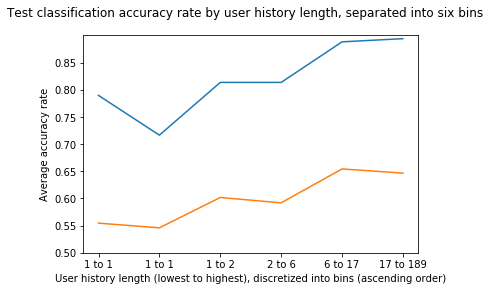

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.698
[1,   400] loss: 0.652
[1,   600] loss: 0.540
[1,   800] loss: 0.551
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.419
[2,   400] loss: 0.389
[2,   600] loss: 0.411
[2,   800] loss: 0.407
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.355
[3,   400] loss: 0.391
[3,   600] loss: 0.343
[3,   800] loss: 0.348
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.338
[4,   400] loss: 0.339
[4,   600] loss: 0.366
[4,   800] loss: 0.327
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

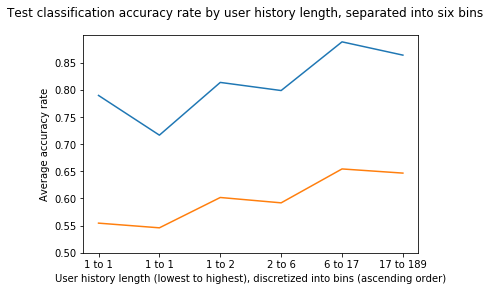

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.657
[1,   400] loss: 0.645
[1,   600] loss: 0.583
[1,   800] loss: 0.537
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.435
[2,   400] loss: 0.420
[2,   600] loss: 0.431
[2,   800] loss: 0.381
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.358
[3,   400] loss: 0.362
[3,   600] loss: 0.355
[3,   800] loss: 0.373
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.346
[4,   400] loss: 0.349
[4,   600] loss: 0.360
[4,   800] loss: 0.325
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = 0.08843537414965985
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = 0.12727272727272743
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + s

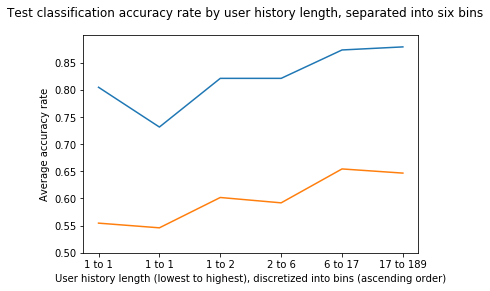

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.676
[1,   400] loss: 0.634
[1,   600] loss: 0.524
[1,   800] loss: 0.516
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.406
[2,   400] loss: 0.376
[2,   600] loss: 0.432
[2,   800] loss: 0.402
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.340
[3,   400] loss: 0.374
[3,   600] loss: 0.353
[3,   800] loss: 0.352
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.357
[4,   400] loss: 0.336
[4,   600] loss: 0.334
[4,   800] loss: 0.323
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of

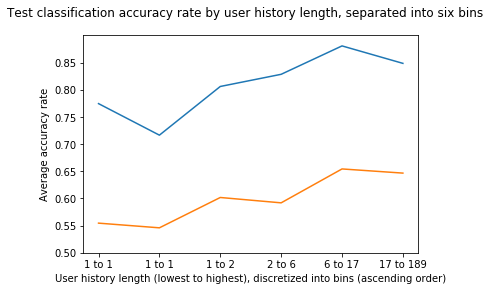

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.693
[1,   400] loss: 0.643
[1,   600] loss: 0.531
[1,   800] loss: 0.500
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.427
[2,   400] loss: 0.399
[2,   600] loss: 0.409
[2,   800] loss: 0.399
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.371
[3,   400] loss: 0.352
[3,   600] loss: 0.368
[3,   800] loss: 0.355
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.331
[4,   400] loss: 0.335
[4,   600] loss: 0.332
[4,   800] loss: 0.380
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = 0.08843537414965985
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + sc

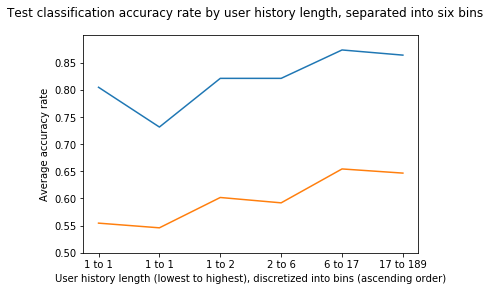

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.622
[1,   400] loss: 0.738
[1,   600] loss: 0.592
[1,   800] loss: 0.505
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.393
[2,   400] loss: 0.439
[2,   600] loss: 0.431
[2,   800] loss: 0.402
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.369
[3,   400] loss: 0.354
[3,   600] loss: 0.362
[3,   800] loss: 0.351
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.346
[4,   400] loss: 0.341
[4,   600] loss: 0.356
[4,   800] loss: 0.321
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.0924761239226648
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + sc

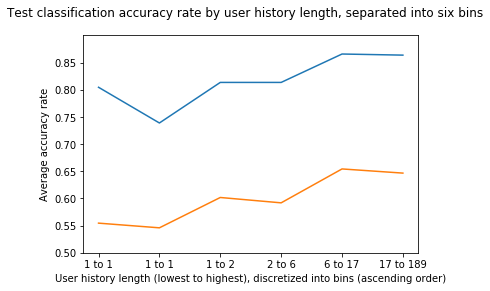

epoch: 0 learning rate: [0.011475172596199481]
[1,   200] loss: 0.713
[1,   400] loss: 0.672
[1,   600] loss: 0.569
[1,   800] loss: 0.468
epoch: 1 learning rate: [0.004403282070589919]
[2,   200] loss: 0.391
[2,   400] loss: 0.437
[2,   600] loss: 0.390
[2,   800] loss: 0.394
epoch: 2 learning rate: [0.0016896384634423845]
[3,   200] loss: 0.370
[3,   400] loss: 0.332
[3,   600] loss: 0.375
[3,   800] loss: 0.341
epoch: 3 learning rate: [0.0006483523179702785]
[4,   200] loss: 0.341
[4,   400] loss: 0.336
[4,   600] loss: 0.344
[4,   800] loss: 0.321
R2 score for bin 0 = 0.13469879518072292
R2 score for bin 1 = -0.0924761239226648
R2 score for bin 2 = 0.16439909297052147
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = 0.23636363636363644
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + 

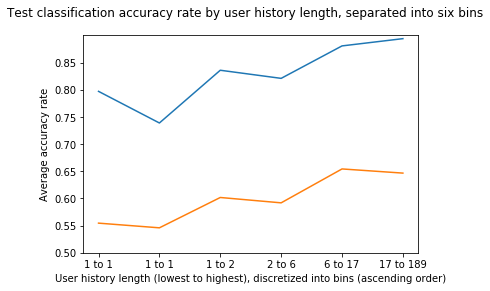

In [14]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)




Acc: 0.8182771535580524
AUC: 0.8713705210452198
F1: 0.881649903473377
Precision: 0.836194259114635
Recall: 0.9330120481927713


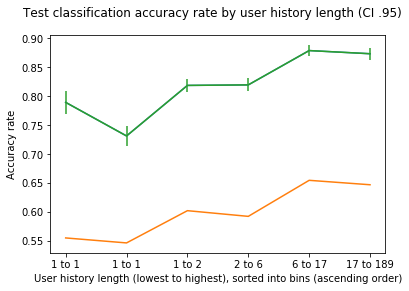

In [15]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)